# BI - Laboratorio 1
Jose David Martinez - 202116677
Manuel Felipe Carvajal - 202014203
Juanita Gil - 



# 0 - Imports

In [19]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Librerías de preprocesamiento y NLP
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Librerías de scikit-learn para modelado
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score


# 1. Carga de Datos

In [20]:
# Cargar el dataset de opiniones
data = pd.read_excel("Datos_proyecto.xlsx")

# Revisar primeras filas
data.head()

# Información general
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


# 2. Entendimiento y preparación de datos

### 2.1 Distribución de clases

En primer lugar se analizó la distribución de clases presentes en el dataset. Este análisis permite identificar cuántas opiniones corresponden a cada uno de los Objetivos de Desarrollo Sostenible considerados en el proyecto: ODS 1 (Fin de la pobreza), ODS 3 (Salud y bienestar) y ODS 4 (Educación de calidad). Los resultados evidencian la cantidad de registros por categoría y permiten observar posibles desbalances entre clases, lo cual es un factor relevante porque puede afectar el desempeño de los modelos de clasificación. Este paso inicial es fundamental para conocer la representatividad de los datos y orientar las decisiones posteriores en cuanto a técnicas de preprocesamiento y modelado.

C:\Users\felip\AppData\Local\Temp\ipykernel_7304\3268480489.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_clases.index, y=conteo_clases.values, palette="viridis")


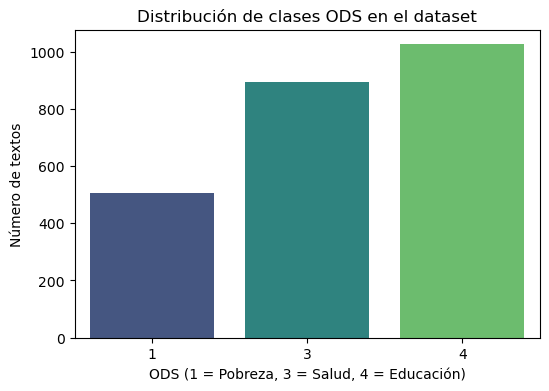

labels
1     505
3     894
4    1025
Name: count, dtype: int64

In [5]:
# Distribución de clases ODS
conteo_clases = data['labels'].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=conteo_clases.index, y=conteo_clases.values, palette="viridis")
plt.title("Distribución de clases ODS en el dataset")
plt.xlabel("ODS (1 = Pobreza, 3 = Salud, 4 = Educación)")
plt.ylabel("Número de textos")
plt.show()

conteo_clases


### 2.2 Análisis de la longitud de los textos.

Con el fin de comprender mejor la naturaleza de los datos, se analizó la longitud de los textos en términos de número de palabras y de caracteres. Este análisis es importante porque permite detectar opiniones demasiado cortas que podrían no aportar información suficiente para el modelo, así como textos muy largos que podrían introducir ruido. Se calcularon estadísticas descriptivas como la media, la desviación estándar, los valores mínimos y máximos, y además se construyó un histograma para visualizar la distribución de longitudes. Los resultados obtenidos ofrecen una idea clara de la variabilidad en la extensión de los textos y constituyen una base para tomar decisiones en la etapa de preprocesamiento, como establecer umbrales mínimos de longitud para conservar las instancias útiles.

       num_palabras  num_caracteres
count   2424.000000     2424.000000
mean     107.924092      683.223185
std       35.575349      223.563695
min       41.000000      303.000000
25%       81.000000      513.000000
50%      102.000000      647.000000
75%      129.000000      809.250000
max      260.000000     1492.000000


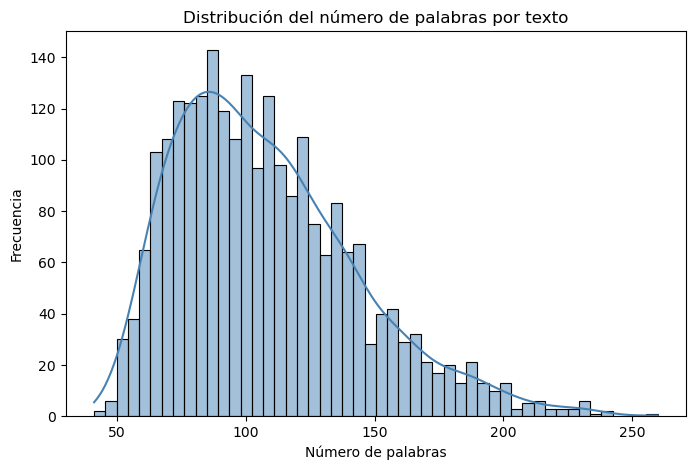

In [6]:
# Crear variables de longitud
data['num_palabras'] = data['textos'].apply(lambda x: len(str(x).split()))
data['num_caracteres'] = data['textos'].apply(lambda x: len(str(x)))

# Estadísticas descriptivas
print(data[['num_palabras','num_caracteres']].describe())

# Histograma de número de palabras
plt.figure(figsize=(8,5))
sns.histplot(data['num_palabras'], bins=50, kde=True, color="steelblue")
plt.title("Distribución del número de palabras por texto")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()


### 2.3 Detección de valores nulos y duplicados.

Como parte del perfilamiento inicial se verificó la existencia de valores nulos y registros duplicados en el dataset. Este paso es indispensable ya que la presencia de datos faltantes o repetidos puede comprometer la calidad del modelo y sesgar los resultados. La revisión se realizó tanto a nivel de columnas como a nivel de filas completas. De esta manera, se garantiza que los textos que ingresen al proceso de preprocesamiento y modelado sean instancias únicas y contengan información válida. En caso de encontrarse valores nulos o duplicados, se deben definir estrategias de tratamiento, como la eliminación de registros o la imputación de información, según corresponda.

In [7]:
# Verificación de valores nulos
nulos = data.isnull().sum()

# Verificación de duplicados
duplicados = data.duplicated().sum()

print("Valores nulos por columna:")
print(nulos)
print(f"\nNúmero de filas duplicadas: {duplicados}")


Valores nulos por columna:
textos            0
labels            0
num_palabras      0
num_caracteres    0
dtype: int64

Número de filas duplicadas: 0


### 2.4 Revisión de ejemplos de textos por clase.

Además de los análisis cuantitativos, se revisaron ejemplos de textos pertenecientes a cada clase con el objetivo de comprender mejor el tipo de lenguaje y los temas asociados a los diferentes ODS. Este ejercicio cualitativo permite verificar que las etiquetas asignadas corresponden de manera coherente al contenido textual, así como identificar palabras o expresiones frecuentes que podrían resultar relevantes para el proceso de clasificación. La exploración de ejemplos reales ayuda a contextualizar los datos y proporciona una visión preliminar sobre las características lingüísticas que diferencian a cada categoría, lo cual será útil para diseñar las transformaciones de texto y evaluar posteriormente la interpretabilidad de los modelos.

In [8]:
# Mostrar ejemplos de textos por clase ODS
for label in sorted(data['labels'].unique()):
    print(f"\nEjemplos de ODS {label}:")
    ejemplos = data[data['labels'] == label]['textos'].sample(3, random_state=42).to_list()
    for i, texto in enumerate(ejemplos, 1):
        # limitar a 300 caracteres por claridad
        print(f"{i}. {texto[:300]}")  



Ejemplos de ODS 1:
1. En tres (Chile, Perú y Uruguay), el efecto de este factor se vio potenciado por una mejora en la distribución, al menos en el área de distribución cercana a la línea de pobreza. Por otro lado, la tendencia a la baja de la pobreza en Argentina y República Dominicana fue, en parte, frenada —no ayudada
2. Por ejemplo, con el umbral de pobreza definido en el 60% de los ingresos medios de un país, en 2006, 72 millones de personas en la UE estaban en riesgo de caer en la pobreza, y en 2001, más de la mitad de todas las personas en hogares con bajos ingresos en la UE vivían con el riesgo persistente de c
3. Pasar de políticas comprometidas de salario mínimo a un reparto mucho más justo de las ganancias de productividad y de los beneficios debería ser un punto de partida. Ya veremos, pero sin duda de esto tratarán la política y las luchas sociales en los próximos años. La capacidad de hacer frente a los

Ejemplos de ODS 3:
1. La sobremedicación es un motivo de preocupaci

### 2.4 Perfilamiento

En esta sección se utilizará pandas_profiling para generar un informe detallado del dataset. El reporte incluirá análisis estadísticos exploratorios como la distribución de las variables, la identificación de valores nulos, la detección de posibles outliers y la evaluación de la correlación entre las variables. Esto permitirá obtener una visión aún más especifica de la calidad y estructura de los datos que a lo mejor no se alcanza a visualizar con solo gráficas tradicionales.

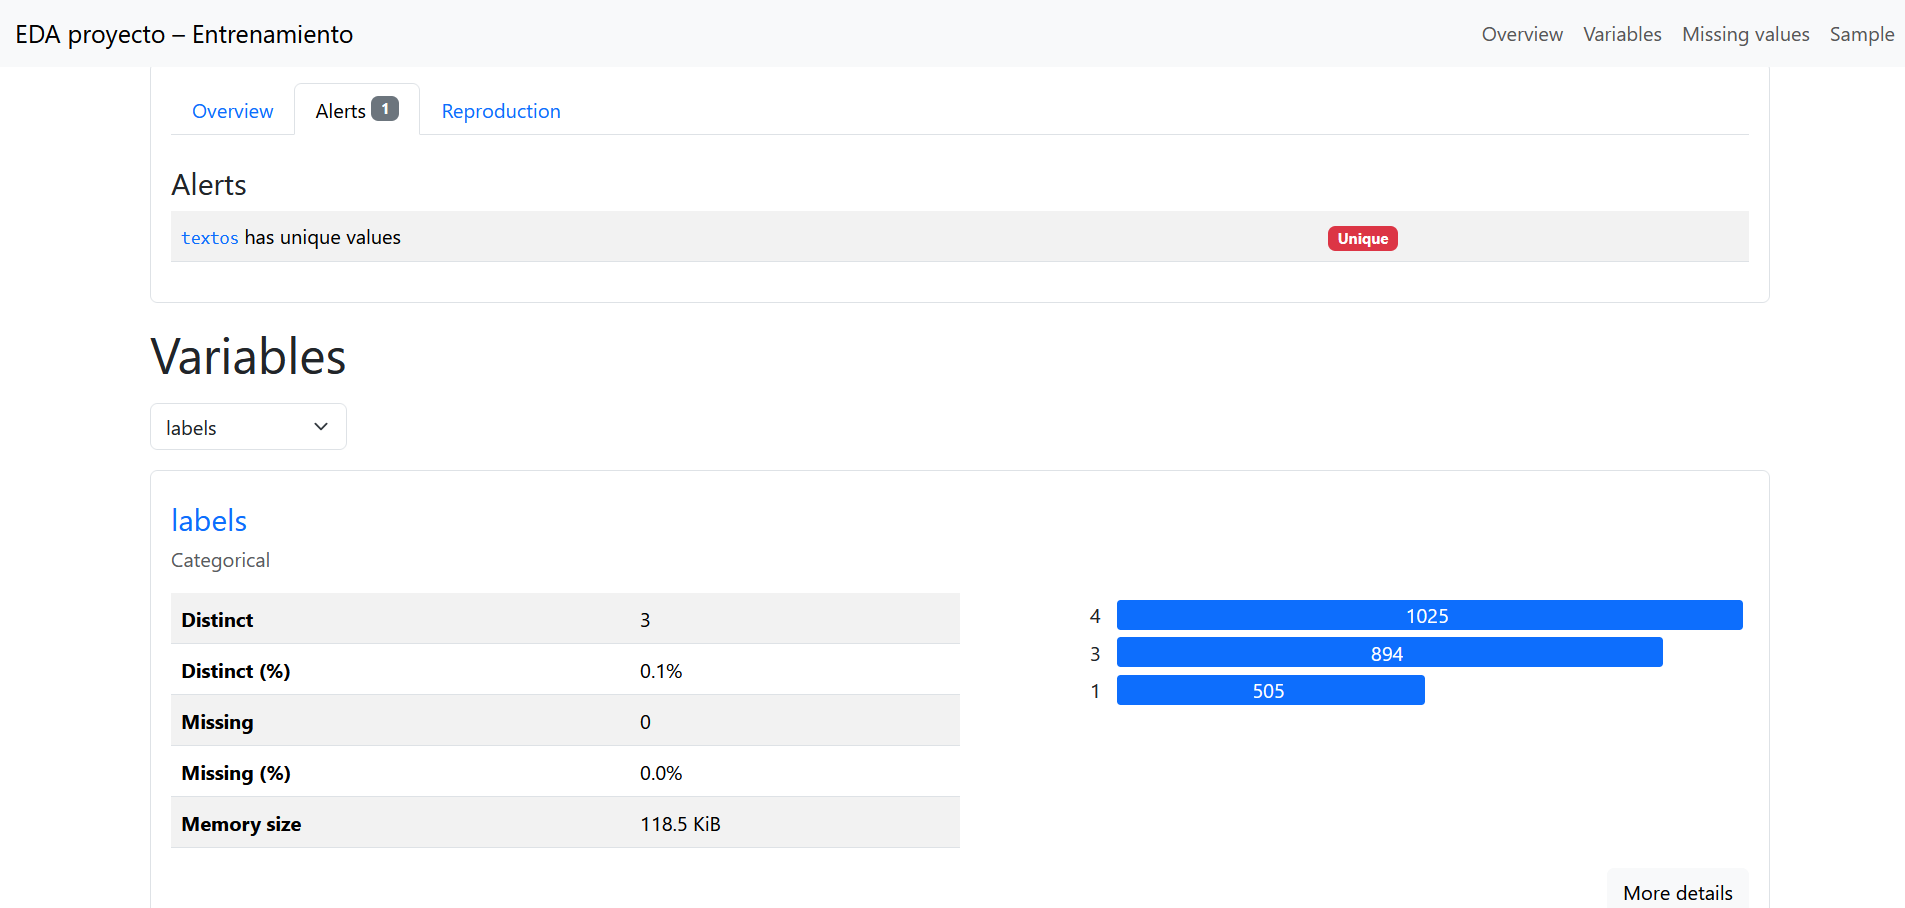

In [9]:
#from ydata_profiling import ProfileReport
# Perfilamiento de los datos a través de ydata_profiling
#df = pd.read_excel("Datos_proyecto.xlsx")
#profile = ProfileReport(df, title="EDA proyecto – Entrenamiento", explorative=True)
#vollver html para explorar mejor
#profile.to_file("eda_proyecto.html")

El conjunto de datos analizado contiene un total de 2.424 observaciones y 2 variables: una columna de texto con las opiniones ciudadanas y una columna categórica con la etiqueta que indica el ODS correspondiente. No se encontraron valores faltantes en ninguna de las columnas, lo que garantiza una completitud del 100 %. Tampoco se identificaron filas duplicadas, de manera que cada registro representa una opinión distinta.


### 2.5 Analisis de calidad


#### 2.5.1 Analisis de Completitud

Se evaluó la completitud de los datos para identificar la presencia de valores faltantes en las columnas de interés. Este análisis permite determinar si el dataset contiene vacíos que puedan afectar el proceso de aprendizaje automático. El cálculo del porcentaje de nulos mostró que tanto la columna de textos como la de etiquetas están completas, lo cual garantiza que no se requiere un tratamiento adicional de imputación o eliminación de registros por ausencia de información.

In [10]:
# Completitud: porcentaje de nulos por columna
completitud = data.isnull().mean() * 100
completitud


textos            0.0
labels            0.0
num_palabras      0.0
num_caracteres    0.0
dtype: float64

#### 2.5.2 Analisis de unicidad

La unicidad se evaluó calculando cuántos textos son distintos dentro del dataset. Este paso es clave porque la existencia de opiniones repetidas puede generar sesgos en el entrenamiento, al darle más peso de manera artificial a ciertos contenidos. El conteo mostró que la gran mayoría de registros son únicos, aunque también se identificaron textos duplicados que deberán ser eliminados para asegurar que cada observación aporte información novedosa al modelo.

In [11]:
# Unicidad: número de registros únicos en textos
num_total = len(data)
num_unicos = data['textos'].nunique()
duplicados = num_total - num_unicos
print(f"Total registros: {num_total}")
print(f"Registros únicos: {num_unicos}")
print(f"Duplicados: {duplicados}")


Total registros: 2424
Registros únicos: 2424
Duplicados: 0


#### 2.5.3 Analisis de validez

Para garantizar la validez de los datos, se revisaron los valores posibles de la columna de etiquetas. Dado que el problema se restringe a los ODS 1, 3 y 4, cualquier valor fuera de este rango representaría un error de codificación. La inspección de la variable confirmó que únicamente aparecen los valores esperados, lo cual asegura que no es necesario realizar correcciones en este aspecto.

In [12]:
# Validez: valores únicos de la columna labels
valores_labels = data['labels'].unique()
print("Valores encontrados en labels:", valores_labels)


Valores encontrados en labels: [4 3 1]


#### 2.5.3 Analisis de consitencia

Finalmente, se evaluó la consistencia interna de los datos, entendida como la coherencia entre el contenido textual y su utilidad para el análisis. Se verificó que no existan opiniones vacías y se identificaron los casos en los que los textos tienen menos de tres palabras, ya que en estos casos la información es insuficiente para que el modelo aprenda patrones significativos. Este tipo de registros serán revisados y posiblemente descartados en la fase de limpieza, con el fin de mantener la integridad del corpus y garantizar resultados confiables.

In [13]:
# Consistencia: textos vacíos o casi vacíos
textos_vacios = data[data['textos'].str.strip().eq("")].shape[0]

# Textos con menos de 3 palabras
textos_cortos = data[data['num_palabras'] < 3].shape[0]

print("Textos vacíos:", textos_vacios)
print("Textos muy cortos (<3 palabras):", textos_cortos)


Textos vacíos: 0
Textos muy cortos (<3 palabras): 0


# 3. Preparación de los Datos

#### 3.1 Normalización

Como primer paso de la preparación se aplicó una normalización básica al texto. Esta consistió en pasar todo el contenido a minúsculas, eliminar acentos, URLs, números y signos de puntuación, además de unificar espacios. El objetivo de estas transformaciones es reducir el ruido en los datos y garantizar que expresiones equivalentes, como “Educación” y “educacion”, sean tratadas de la misma manera por el modelo.

In [22]:
import re
import unidecode

def limpiar_texto(texto):
    # Pasar a minúsculas
    texto = texto.lower()
    # Eliminar acentos
    texto = unidecode.unidecode(texto)
    # Quitar URLs
    texto = re.sub(r"http\S+|www\S+|https\S+", '', texto)
    # Quitar números
    texto = re.sub(r'\d+', '', texto)
    # Quitar puntuación y caracteres especiales
    texto = re.sub(r'[^\w\s]', '', texto)
    # Quitar espacios extras
    texto = texto.strip()
    return texto

data['texto_limpio'] = data['textos'].apply(limpiar_texto)
data[['textos','texto_limpio']].head(5)


,textos,texto_limpio
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",aprendizaje y educacion se consideran sinonimo...
1,Para los niños más pequeños (bebés y niños peq...,para los ninos mas pequenos bebes y ninos pequ...
2,"Además, la formación de especialistas en medic...",ademas la formacion de especialistas en medici...
3,En los países de la OCDE se tiende a pasar de ...,en los paises de la ocde se tiende a pasar de ...
4,Este grupo se centró en las personas que padec...,este grupo se centro en las personas que padec...


In [ ]:
import re, unidecode
import pandas as pd

def normalizar(texto: str) -> str:
    t = str(texto)
    t = t.lower()
    t = unidecode.unidecode(t)
    t = re.sub(r"http\S+|www\S+|https\S+", " ", t)      # URLs
    t = re.sub(r"\S+@\S+", " ", t)                      # correos
    t = re.sub(r"@\w+|#\w+", " ", t)                    # @menciones y hashtags
    t = re.sub(r"\d+", " ", t)                          # números
    t = re.sub(r"[^\w\s]", " ", t)                      # signos y símbolos
    t = re.sub(r"\s+", " ", t).strip()                  # espacios múltiples
    return t

data = data.copy()  
data["texto_norm"] = data["textos"].apply(normalizar)

# Muestra de 5 ejemplos reales
ej_norm = data.sample(5, random_state=7)[["textos", "texto_norm"]]
ej_norm


,textos,texto_norm
1355,"Además, la Escuela de Educación a Distancia de...",ademas la escuela de educacion a distancia de ...
1770,Esto puede conducir a un bajo uso de la capaci...,esto puede conducir a un bajo uso de la capaci...
240,Se han realizado varios esfuerzos para hacer f...,se han realizado varios esfuerzos para hacer f...
1604,Más de la mitad de los estudiantes nacionales ...,mas de la mitad de los estudiantes nacionales ...
1871,El cuarto enfoque añadía a las sesiones de for...,el cuarto enfoque anadia a las sesiones de for...


#### 3.2 Tokenización y stopwords

Posteriormente, se realizó la tokenización de cada opinión en palabras y se eliminaron las stopwords en español, es decir, aquellas palabras muy frecuentes que no aportan significado discriminativo al modelo, como “que”, “de”, “el” o “pero”. Esta reducción mejora la representatividad de las características relevantes para diferenciar entre las categorías ODS

In [23]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords_es = set(stopwords.words('spanish'))

def eliminar_stopwords(texto):
    tokens = texto.split()
    tokens_filtrados = [t for t in tokens if t not in stopwords_es]
    return " ".join(tokens_filtrados)

data['texto_limpio'] = data['texto_limpio'].apply(eliminar_stopwords)
data[['textos','texto_limpio']].head(5)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\felip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,textos,texto_limpio
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",aprendizaje educacion consideran sinonimos esc...
1,Para los niños más pequeños (bebés y niños peq...,ninos mas pequenos bebes ninos pequenos capaci...
2,"Además, la formación de especialistas en medic...",ademas formacion especialistas medicina genera...
3,En los países de la OCDE se tiende a pasar de ...,paises ocde tiende pasar cursos obligatorios o...
4,Este grupo se centró en las personas que padec...,grupo centro personas padecen trastornos menta...


#### 3.3 Lematización

Con el fin de homogenizar las palabras a su forma base, se aplicó lematización utilizando el modelo de spaCy en español. Gracias a esta técnica, diferentes variaciones de una misma palabra, como “aprendiendo” y “aprendí”, se reducen a la raíz “aprender”, lo cual favorece la capacidad del modelo para identificar patrones semánticos.

In [25]:
import spacy
nlp = spacy.load("es_core_news_sm")

def lematizar(texto):
    doc = nlp(texto)
    return " ".join([token.lemma_ for token in doc])

data['texto_limpio'] = data['texto_limpio'].apply(lematizar)
data[['textos','texto_limpio']].head(5)


,textos,texto_limpio
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",aprendizaje educacion considerar sinonimo esco...
1,Para los niños más pequeños (bebés y niños peq...,nino mas pequeno beb nino pequeno capacitacion...
2,"Además, la formación de especialistas en medic...",adema formacion especialista medicín general t...
3,En los países de la OCDE se tiende a pasar de ...,país ocde tender pasar curso obligatorio optat...
4,Este grupo se centró en las personas que padec...,grupo centro persona padecer trastorno mental ...


#### 3.4 Representación vectorial

Finalmente, los textos procesados se transformaron en representaciones numéricas mediante TF-IDF, una técnica que asigna un peso a cada palabra en función de su frecuencia en el documento y en el corpus total. Para capturar expresiones compuestas se consideraron unigramas y bigramas, y se limitó el vocabulario a un máximo de veinte mil términos con el fin de controlar la dimensionalidad.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizador = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X = vectorizador.fit_transform(data['texto_limpio'])
y = data['labels']

X.shape


(2424, 20000)